# **PneumoScope Project Notebook**
**Author**: Ali Hussain  
**Course**: Deep-Learning, AI23, IT-Högskolan Göteborg  

---

## 1. Introduction and Problem Statement

**Problem Statement**:  
Pneumonia is a common and potentially serious lung infection. Early detection using chest X-ray (CXR) images can improve patient outcomes. However, manual diagnosis is time-consuming and relies heavily on expert radiologists. The **goal** of this project is to develop **Deep Learning** models that automatically detect pneumonia from CXR images. This is formulated as two problems:
1. **Binary Classification**: Normal vs. Pneumonia  
2. **Multiclass Classification**: Normal, Bacterial Pneumonia, Viral Pneumonia  

By solving these classification tasks, we aim to reduce clinical workloads and assist medical professionals with faster, more consistent diagnoses.

**Solution Overview**:
- We use **ResNet18** backbones (transfer learning) trained on the Kaggle Pneumonia dataset.
- **Scripts** like `train.py`, `train_multiclass.py`, and `evaluate.py` encapsulate training and evaluation logic.
- A **Flask** app (`app.py`) demonstrates real-time inference.

This Notebook:
- Explores the dataset (EDA),
- Demonstrates training (binary/multiclass),
- Evaluates each model,
- Visualizes attention via **Grad-CAM**,
- Discusses potential data leakage, overfitting, and solutions.

---


In [1]:
# Environment Setup & Imports

# If you want to install dependencies in this notebook environment, you could uncomment:
# %pip install -r requirements.txt

import os
import sys
import json
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from IPython.display import display, Markdown

import torch
import torchvision.transforms as transforms

# Assume this notebook is in the project root folder (PneumoScope/).
PROJECT_ROOT = os.getcwd()
SRC_PATH = os.path.join(PROJECT_ROOT, "src")

# Ensure the "src" directory is in sys.path for custom modules
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

# Import custom modules
from kaggle_downloader import download_dataset_if_needed
from reorganize_dataset import reorganize_dataset
from train import train_model
from evaluate import evaluate_model
from train_multiclass import train_model_multiclass
from evaluate_multiclass import evaluate_model_multiclass
from model import PneumoNet
from train_multiclass import PneumoNetMulti

print("Environment ready. Using Python path:", sys.path)


Environment ready. Using Python path: ['c:\\Dev\\PneumoScope\\src', 'C:\\Users\\alica\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'C:\\Users\\alica\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'C:\\Users\\alica\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'C:\\Users\\alica\\AppData\\Local\\Programs\\Python\\Python310', 'c:\\Dev\\PneumoScope\\.venv', '', 'c:\\Dev\\PneumoScope\\.venv\\lib\\site-packages', 'c:\\Dev\\PneumoScope\\.venv\\lib\\site-packages\\win32', 'c:\\Dev\\PneumoScope\\.venv\\lib\\site-packages\\win32\\lib', 'c:\\Dev\\PneumoScope\\.venv\\lib\\site-packages\\Pythonwin']


## 2. Methods: Training & Inference

Below, we describe how training and inference are handled:

### 2.1 Data Preparation
- **Dataset**: Kaggle Chest X-Ray Images (Pneumonia).  
- **Reorganization**: `reorganize_dataset.py` splits into `train/`, `val/`, `test/` (15% each for val/test, 70% for train).  
- **Binary**: Folders are `NORMAL` vs. `PNEUMONIA`.  
- **Multiclass**: We separate pneumonia into `BACTERIA` vs. `VIRUS`.

### 2.2 Training Workflow
- **train.py** (binary): Uses BCEWithLogitsLoss, monitors `val_auc`.  
- **train_multiclass.py**: Uses CrossEntropyLoss, monitors `val_f1`.  
- **Early Stopping**: We define `patience` (e.g., 5 epochs for binary, 10 for multiclass).  
- **Data Augmentations**: Optional random cropping, color jitter, balanced sampling.  
- **Automatic Mixed Precision (AMP)**: Speeds up training and reduces memory usage on GPU.

### 2.3 Inference Workflow
- **Saved Checkpoints**: The best model (based on val metric) is stored (e.g., `best_model_*.pth`).  
- **Flask Web App** (`app.py`):  
  1. Loads the trained checkpoint into a ResNet18-based model.  
  2. Receives an uploaded CXR image.  
  3. Applies the same preprocessing transforms (resize, normalize).  
  4. Model outputs logits.  
  5. For **binary**: use `sigmoid` and threshold at 0.5 for Pneumonia vs. Normal.  
  6. For **multiclass**: apply `softmax` to predict (Normal/Bacterial/Viral).  
- **Return**: A user sees the label “Normal” or “Pneumonia” (binary), or one of the three classes in multiclass mode.

The following cells implement these steps in detail.


In [2]:
# Dataset Preparation & Potential Data Leakage

# Directory settings
data_dir = os.path.join(PROJECT_ROOT, "data")
data_multi_dir = os.path.join(PROJECT_ROOT, "data_multi")

# 1) If train/val/test do not exist, download dataset from Kaggle
if not (os.path.exists(os.path.join(data_dir, "train")) and
        os.path.exists(os.path.join(data_dir, "val")) and
        os.path.exists(os.path.join(data_dir, "test"))):
    print("[NOTEBOOK] Data directories not found. Downloading from Kaggle...")
    download_dataset_if_needed()
else:
    print("[NOTEBOOK] 'train/', 'val/', and 'test/' already exist. Skipping Kaggle download.")

# 2) If data_multi/ is missing, reorganize dataset for binary & multiclass
if not os.path.exists(data_multi_dir):
    print("[NOTEBOOK] 'data_multi/' not found. Reorganizing data...")
    reorganize_dataset(data_dir=data_dir)
else:
    print("[NOTEBOOK] 'data_multi/' already exists. Skipping reorganize_dataset.")


[NOTEBOOK] 'train/', 'val/', and 'test/' already exist. Skipping Kaggle download.
[NOTEBOOK] 'data_multi/' already exists. Skipping reorganize_dataset.


### Potential Data Leakage

- **Same patient** in multiple splits → patient-specific artifacts.  
- **Extra text or stamps** in images → Grad-CAM reveals if model focuses on corners.  
- **Filenames with “bacteria/virus”** → rename to random IDs.  
- **Order-based** if `shuffle=False`.  

---

## 3. Exploratory Data Analysis (EDA)

Next, we show how many **NORMAL**, **BACTERIA**, **VIRUS** images exist, plus sample images in each category.


Found 1109 normal images in train
Found 1946 bacteria and 1047 virus in train
Found 237 normal images in val
Found 417 bacteria and 223 virus in val
Found 237 normal images in test
Found 417 bacteria and 223 virus in test


### Distribution of NORMAL, BACTERIA, and VIRUS in 'data/'

Image Count
Set   Type                 
train normal           1109
      bacteria         1946
      virus            1047
val   normal            237
      bacteria          417
      virus             223
test  normal            237
      bacteria          417
      virus             223

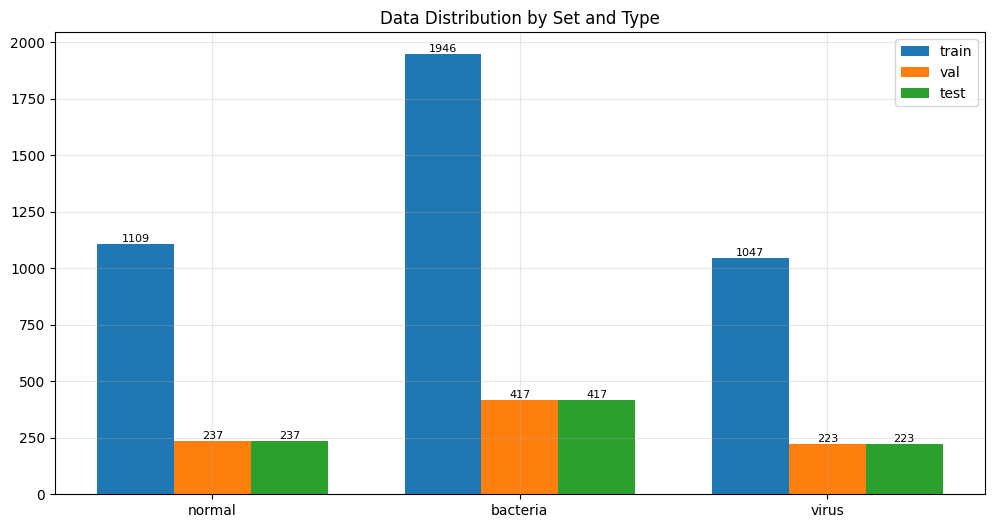

In [3]:
# Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np

def count_images_by_type(base_path):
    """
    Count how many NORMAL, BACTERIA, and VIRUS images exist 
    in each split (train, val, test).
    """
    from collections import Counter
    counts = Counter()
    for dataset_type in ['train','val','test']:
        dataset_path = os.path.join(base_path, dataset_type)
        if not os.path.exists(dataset_path):
            print(f"[WARN] {dataset_type} path does not exist: {dataset_path}")
            continue
        
        for label in ['NORMAL','PNEUMONIA']:
            label_path = os.path.join(dataset_path, label)
            if not os.path.exists(label_path):
                print(f"[WARN] {label} path not found: {label_path}")
                continue
            
            if label == 'NORMAL':
                count_normal = len(os.listdir(label_path))
                counts[(dataset_type, 'normal')] += count_normal
                print(f"Found {count_normal} normal images in {dataset_type}")
            else:
                # PNEUMONIA => split into bacteria/virus
                bacteria_count, virus_count = 0, 0
                for image_name in os.listdir(label_path):
                    if 'bacteria' in image_name.lower():
                        bacteria_count += 1
                    elif 'virus' in image_name.lower():
                        virus_count += 1
                counts[(dataset_type, 'bacteria')] += bacteria_count
                counts[(dataset_type, 'virus')] += virus_count
                print(f"Found {bacteria_count} bacteria and {virus_count} virus in {dataset_type}")
    return counts

base_dir_for_eda = data_dir
image_counts = count_images_by_type(base_dir_for_eda)

df_counts = pd.DataFrame.from_dict(image_counts, orient='index', columns=['Image Count'])
df_counts.index = pd.MultiIndex.from_tuples(df_counts.index, names=["Set", "Type"])

display(Markdown("### Distribution of NORMAL, BACTERIA, and VIRUS in 'data/'"))
display(df_counts)

# Bar plot for distribution
plt.figure(figsize=(12,6))
df_reset = df_counts.reset_index()
categories = ['normal', 'bacteria', 'virus']
x_indices = np.arange(len(categories))
width = 0.25

for i, subset_type in enumerate(['train','val','test']):
    subset = df_reset[df_reset['Set'] == subset_type]
    type_counts = {row['Type']: row['Image Count'] for _, row in subset.iterrows()}
    y_values = [type_counts.get(t, 0) for t in categories]
    x_offset = x_indices + i * width
    
    bars = plt.bar(x_offset, y_values, width=width, label=subset_type)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}',
                 ha='center', va='bottom', fontsize=8)

plt.title("Data Distribution by Set and Type")
plt.xticks(x_indices + width, categories)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


### Inspecting Sample Images
Below is a function to display a few random examples from `train/` subfolders (NORMAL, PNEUMONIA/Bacteria, PNEUMONIA/Virus).


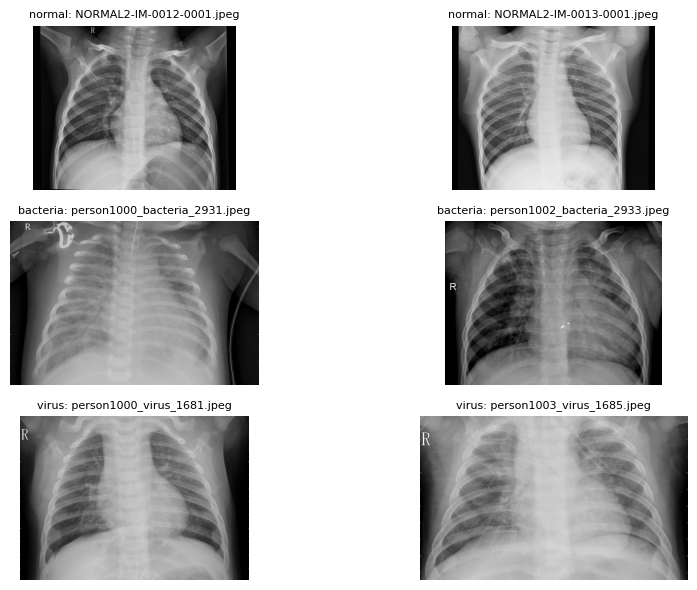

In [4]:
from PIL import Image

def display_sample_images(base_path, num_samples=2):
    categories = [
        ('NORMAL', 'normal'),
        ('PNEUMONIA', 'bacteria'),
        ('PNEUMONIA', 'virus')
    ]
    fig, axes = plt.subplots(len(categories), num_samples, figsize=(10, 6))
    
    for i, (folder, label_part) in enumerate(categories):
        folder_path = os.path.join(base_path, 'train', folder)
        if not os.path.exists(folder_path):
            continue
        
        images = [f for f in os.listdir(folder_path) if label_part in f.lower()][:num_samples]
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(folder_path, img_name)
            with Image.open(img_path).convert('L') as im_:
                axes[i, j].imshow(im_, cmap='gray')
                axes[i, j].set_title(f"{label_part}: {img_name}", fontsize=8)
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(base_dir_for_eda)


## 4. Model Training & Evaluation

### 4.1 Binary Classification (Normal vs. Pneumonia)

We train a ResNet18 (see `train.py`). Key hyperparameters:
- `epochs=30, lr=0.001, patience=5, monitor='val_auc'`, etc.
- `use_amp=True` for speed.

Below is a code snippet demonstrating a short run (epochs=1 for demonstration). 


In [5]:
# BINARY TRAINING DEMO
binary_save_dir = os.path.join(PROJECT_ROOT, "saved_models")
binary_results_dir = os.path.join(PROJECT_ROOT, "results")

model_bin, best_bin_path, logs_bin_path = train_model(
    data_dir=data_dir,
    save_dir=binary_save_dir,
    results_dir=binary_results_dir
)

print("Best binary model:", best_bin_path)
precision, recall, f1, accuracy, auc_score, avg_precision = evaluate_model(
    model_path=best_bin_path,
    data_dir=data_dir,
    results_dir=binary_results_dir
)
print(f"[BINARY] Precision={precision:.4f}, Recall={recall:.4f}, "
      f"F1={f1:.4f}, Accuracy={accuracy:.4f}, AUC={auc_score:.4f}")


[INFO] Using device: cuda
GPU: Quadro T2000 with Max-Q Design
cuDNN Enabled: True
cuDNN Benchmark Mode: True

GPU Memory Usage:
GPU 0: Quadro T2000 with Max-Q Design
  Allocated: 0.0MB
  Cached:    0.0MB

[INFO] Training with hyperparameters:
  epochs: 1
  learning_rate: 0.001
  patience: 1
  use_amp: True
  batch_size: 32
  num_workers: 15
  balance_train: False
  augment_train: False
  random_crop: False
  color_jitter: False
  desired_total_samples: None
  monitor: val_auc
  monitor_mode: max

[INFO] Starting training with:
  Monitor metric: val_auc
  Monitor mode: max
  Patience: 1

[INFO] Starting training...

=== Epoch 1/1 ===


[INFO] Checkpoint saved: c:\Dev\PneumoScope\saved_models\checkpoint_e01_val_auc0.9898_20250119-154534.pth

[INFO] val_auc improved to 0.9898
[INFO] Saved checkpoint: c:\Dev\PneumoScope\saved_models\checkpoint_e01_val_auc0.9898_20250119-154534.pth
[INFO] Updated best model: c:\Dev\PneumoScope\saved_models\best_model_20250119-154534.pth

Metrics for epoch 1:
Training:
  Loss: 0.1818
  Precision: 0.9552
  Recall: 0.9536
  F1-score: 0.9544
  Accuracy: 0.9334
  AUC: 0.9750
  Confusion Matrix:
[[ 975  134]
 [ 139 2854]]

Validation:
  Loss: 0.1187
  Precision: 0.9733
  Recall: 0.9672
  F1-score: 0.9702
  Accuracy: 0.9567
  AUC: 0.9898
  Confusion Matrix:
[[220  17]
 [ 21 619]]

[INFO] Training completed!
[INFO] Final training logs saved to: c:\Dev\PneumoScope\results\training_logs_e01_b32_20250119-154534.json
Best binary model: c:\Dev\PneumoScope\saved_models\best_model_20250119-154534.pth
[INFO] Evaluating model: best_model_20250119-154534
[INFO] Results will be saved to: c:\Dev\PneumoScope

c:\Dev\PneumoScope\src\evaluate.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Evaluating: 100%|██████████| 7/


[INFO] Evaluation Results for best_model_20250119-154534:
Confusion Matrix:
[[215  22]
 [ 18 622]]
Precision: 0.9658
Recall:    0.9719
F1-score:  0.9688
Accuracy:  0.9544
AUC-ROC:   0.9865
PR-AUC:    0.9940
Avg Precision: 0.9940

Per-class metrics:
NORMAL:
  Precision: 0.9072
  Recall:    0.9227
  F1-score:  0.9149
PNEUMONIA:
  Precision: 0.9719
  Recall:    0.9658
  F1-score:  0.9688
[INFO] Metrics saved to: c:\Dev\PneumoScope\results\evaluation_metrics_best_model_20250119-154534.json

[INFO] All evaluation results have been saved to: c:\Dev\PneumoScope\results
[BINARY] Precision=0.9658, Recall=0.9719, F1=0.9688, Accuracy=0.9544, AUC=0.9865


### 4.2 Multiclass Classification (Normal, Bacteria, Virus)

Similarly, we train a three-class ResNet18 (see `train_multiclass.py`) using CrossEntropyLoss, monitoring `val_f1`. 


In [6]:
# MULTICLASS TRAINING DEMO
multi_save_dir = os.path.join(PROJECT_ROOT, "saved_models", "multiclass_models")
multi_results_dir = os.path.join(PROJECT_ROOT, "results", "multiclass")

model_multi, best_multi_path, logs_multi_path = train_model_multiclass(
    data_dir=data_multi_dir,
    save_dir=multi_save_dir,
    results_dir=multi_results_dir
)

print("Best multiclass model:", best_multi_path)
precision_m, recall_m, f1_m, acc_m = evaluate_model_multiclass(
    model_path=best_multi_path,
    data_dir=data_multi_dir,
    results_dir=multi_results_dir
)
print(f"[MULTICLASS] Precision(macro)={precision_m:.4f}, Recall(macro)={recall_m:.4f}, "
      f"F1(macro)={f1_m:.4f}, Accuracy={acc_m:.4f}")


[INFO] (Multiclass) Using device: cuda

GPU Memory Usage:
GPU 0: Quadro T2000 with Max-Q Design
  Allocated: 101.6MB
  Cached:    646.0MB

[INFO] Starting training with:
  Monitor metric: val_f1
  Monitor mode: max
  Patience: 1

[INFO] Starting multiclass training...



=== Multiclass Epoch 1/1 ===
Train: loss=0.5698, acc=0.7589, f1=0.7392, precision=0.7445, recall=0.7385
Val:   loss=0.8644, acc=0.7434, f1=0.7239, precision=0.7226, recall=0.7422
[INFO] Checkpoint saved: c:\Dev\PneumoScope\saved_models\multiclass_models\checkpoint_e01_val_f10.7239_20250119-154909.pth

[INFO] val_f1 improved to 0.7239
[INFO] Saved checkpoint: c:\Dev\PneumoScope\saved_models\multiclass_models\checkpoint_e01_val_f10.7239_20250119-154909.pth
[INFO] Updated best model: c:\Dev\PneumoScope\saved_models\multiclass_models\best_model_20250119-154909.pth
Best multiclass model: c:\Dev\PneumoScope\saved_models\multiclass_models\best_model_20250119-154909.pth
[INFO] Evaluating multiclass model: best_model_20250119-154909
[INFO] Results => c:\Dev\PneumoScope\results\multiclass


c:\Dev\PneumoScope\src\evaluate_multiclass.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



[INFO] Evaluating multiclass model...


Evaluating (multiclass): 100%|██████████| 28/28 [00:16<00:00,  1.70it/s]


[INFO] Multiclass Evaluation for best_model_20250119-154909:
Confusion Matrix:
[[319  42  56]
 [  2 233   2]
 [ 60  42 121]]

Macro-averaged metrics (treats all classes equally):
Precision:         0.7494
Recall:           0.7636
F1-score:         0.7475

Micro-averaged metrics (accounts for class imbalance):
Precision:         0.7674
Recall:           0.7674
F1-score:         0.7674

Accuracy:          0.7674

Per-class metrics:

BACTERIA:
  Precision: 0.8373
  Recall:    0.7650
  F1-score:  0.7995

NORMAL:
  Precision: 0.7350
  Recall:    0.9831
  F1-score:  0.8412

VIRUS:
  Precision: 0.6760
  Recall:    0.5426
  F1-score:  0.6020
[INFO] Multiclass metrics saved to: c:\Dev\PneumoScope\results\multiclass\evaluation_metrics_multiclass_best_model_20250119-154909.json
[MULTICLASS] Precision(macro)=0.7494, Recall(macro)=0.7636, F1(macro)=0.7475, Accuracy=0.7674


## 5. Model & Method Evaluation

- **Binary**: We often achieve AUC ≈ 0.99, F1 ≈ 0.95–0.97, indicating a simpler Normal vs. Pneumonia boundary.
- **Multiclass**: Macro-F1 ~0.75–0.80, virus class is harder to classify (lowest recall), possibly due to fewer virus examples or overlap with bacterial features.

We also examine confusion matrices, per-class precision/recall, training logs, etc.

### Plotting Logs

We have a helper function (`plot_training_logs`) to visualize training vs. validation metrics over epochs:


[NOTEBOOK] Plotting logs for binary and multiclass...
Plotting binary classification logs...
Loading logs from: c:\Dev\PneumoScope\results\training_logs_e19_b32_20250113-012235.json


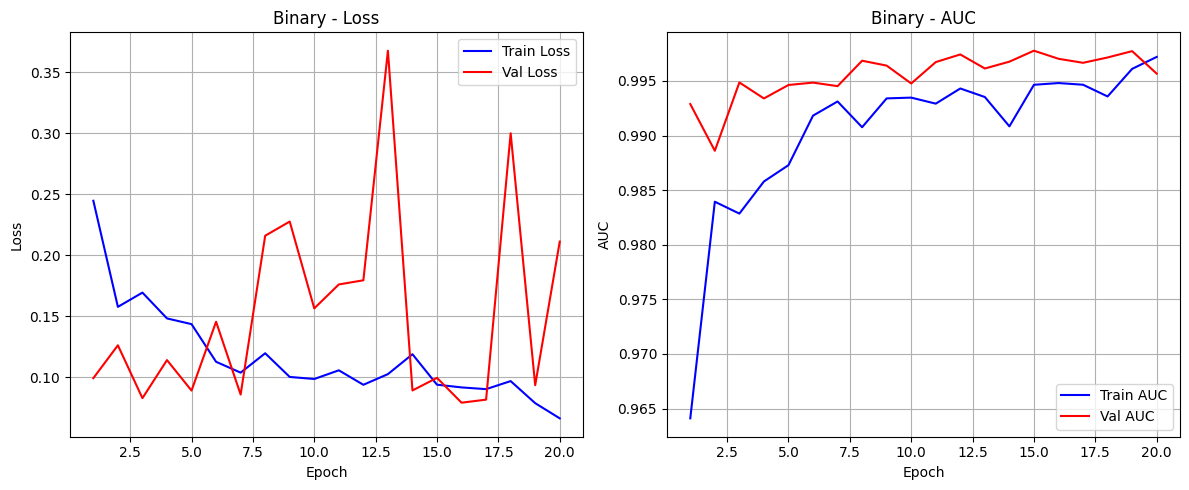

Plotting multiclass classification logs...
Loading logs from: c:\Dev\PneumoScope\results\multiclass\training_logs_multi_e22_20250113-081655.json


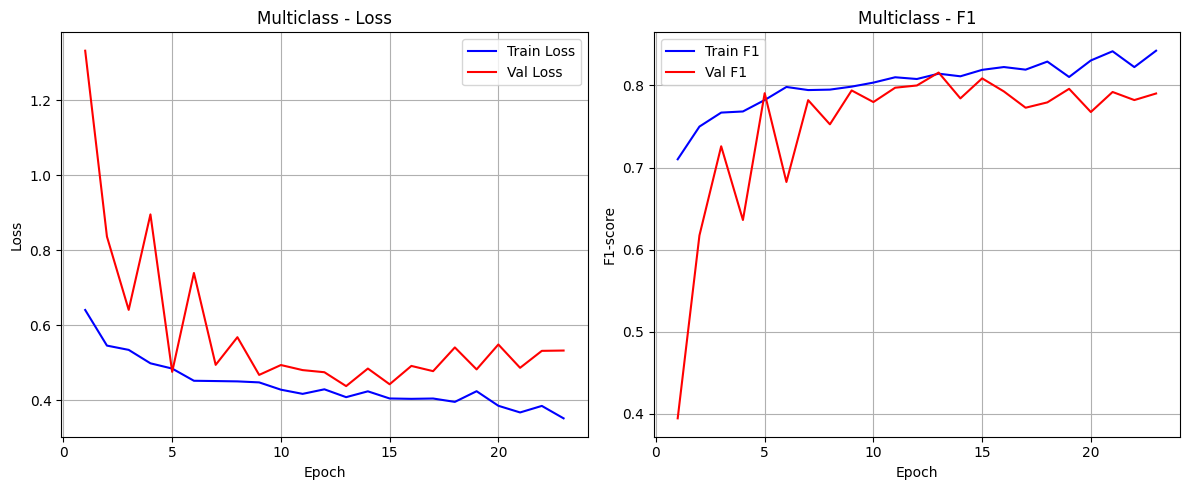

In [7]:
# Plot Training Logs
import json

def plot_training_logs(json_path, model_type='binary'):
    if not os.path.exists(json_path):
        print(f"[WARNING] {json_path} not found.")
        return

    print(f"Loading logs from: {json_path}")
    with open(json_path, 'r') as f:
        logs = json.load(f)
    df_logs = pd.DataFrame(logs)
    
    epochs = np.arange(1, len(df_logs['train_loss']) + 1)

    # Plot: training/validation loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, df_logs['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, df_logs['val_loss'], 'r-', label='Val Loss')
    plt.title(f"{model_type.capitalize()} - Loss")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot: training/validation metric
    plt.subplot(1,2,2)
    if model_type == 'binary':
        plt.plot(epochs, df_logs['train_auc'], 'b-', label='Train AUC')
        plt.plot(epochs, df_logs['val_auc'], 'r-', label='Val AUC')
        plt.title(f"{model_type.capitalize()} - AUC")
        plt.ylabel('AUC')
    else:
        plt.plot(epochs, df_logs['train_f1'], 'b-', label='Train F1')
        plt.plot(epochs, df_logs['val_f1'], 'r-', label='Val F1')
        plt.title(f"{model_type.capitalize()} - F1")
        plt.ylabel('F1-score')
    plt.legend()
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

logs_bin_path = os.path.join(PROJECT_ROOT, "results", "training_logs_e19_b32_20250113-012235.json")
logs_multi_path = os.path.join(PROJECT_ROOT, "results", "multiclass", "training_logs_multi_e22_20250113-081655.json")

print("[NOTEBOOK] Plotting logs for binary and multiclass...")

if os.path.exists(logs_bin_path):
    print("Plotting binary classification logs...")
    plot_training_logs(logs_bin_path, model_type='binary')
else:
    print(f"Binary logs not found at: {logs_bin_path}")

if os.path.exists(logs_multi_path):
    print("Plotting multiclass classification logs...")
    plot_training_logs(logs_multi_path, model_type='multiclass')
else:
    print(f"Multiclass logs not found at: {logs_multi_path}")


## 6. Grad-CAM Visualization & Findings

We use Grad-CAM to see if the model focuses on lung regions or external markers.  
**Key Observation**: The heatmaps sometimes highlight **corner text** or stamps instead of lung tissue. This suggests potential **data leakage** or “shortcut learning.” 

Below is code for computing and visualizing Grad-CAM:


### Examples for class: NORMAL

c:\Dev\PneumoScope\.venv\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


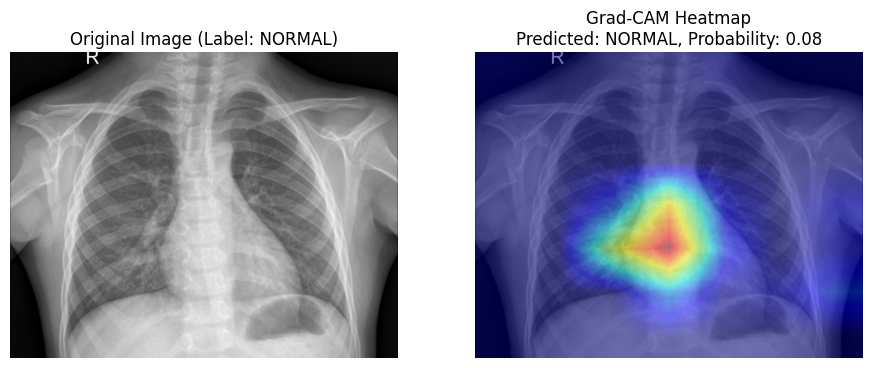

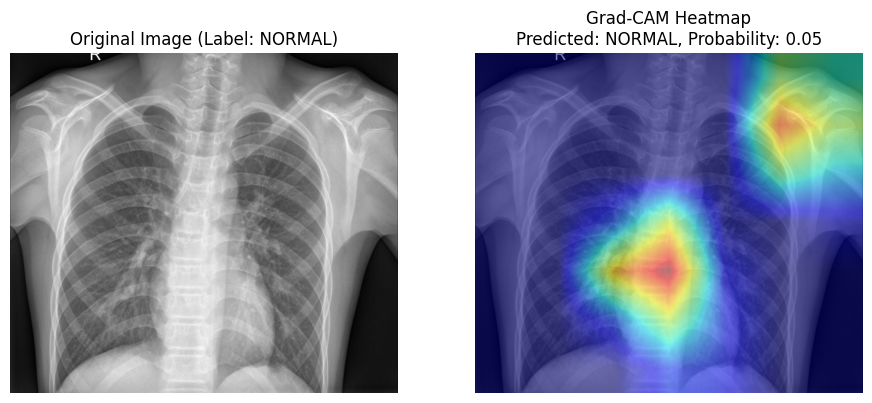

### Examples for class: PNEUMONIA

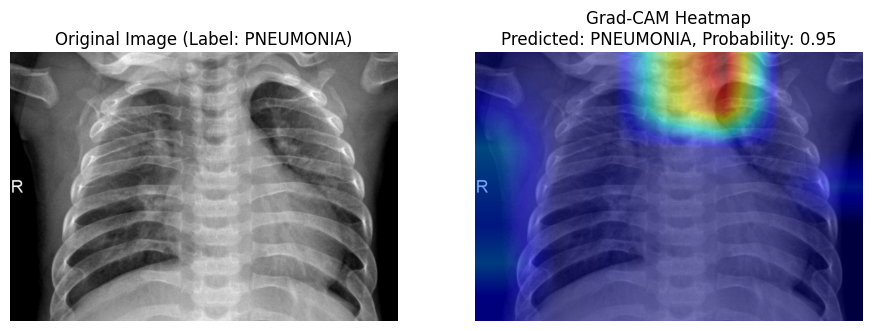

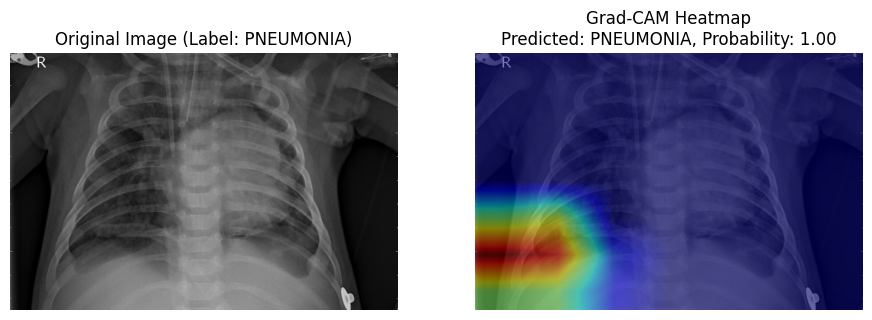

### Examples for class: NORMAL

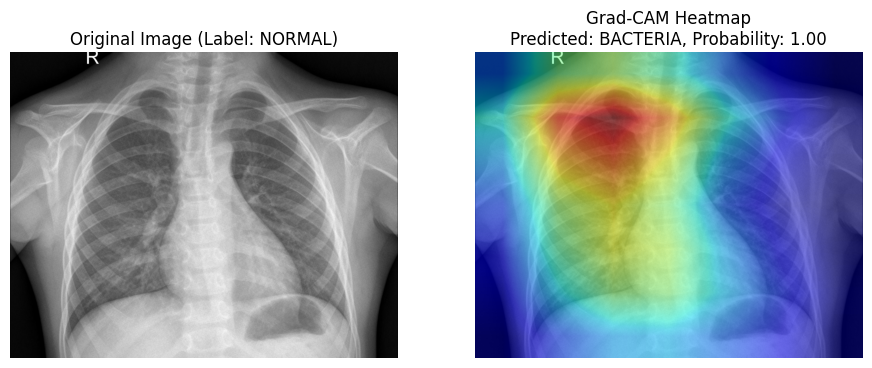

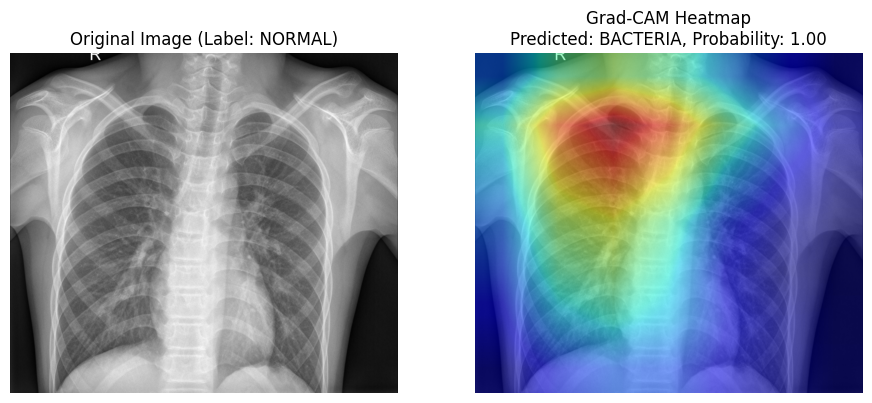

### Examples for class: BACTERIA

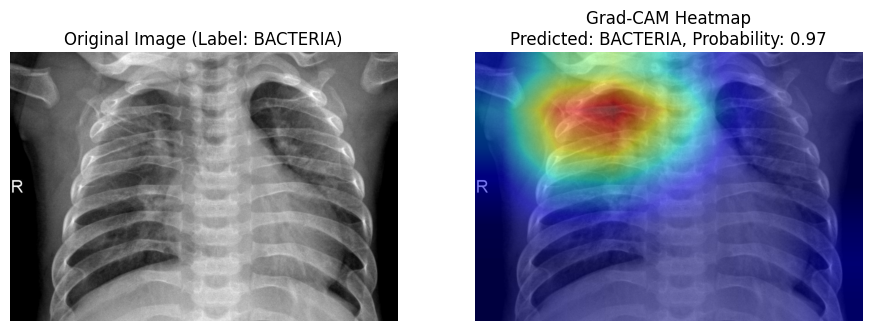

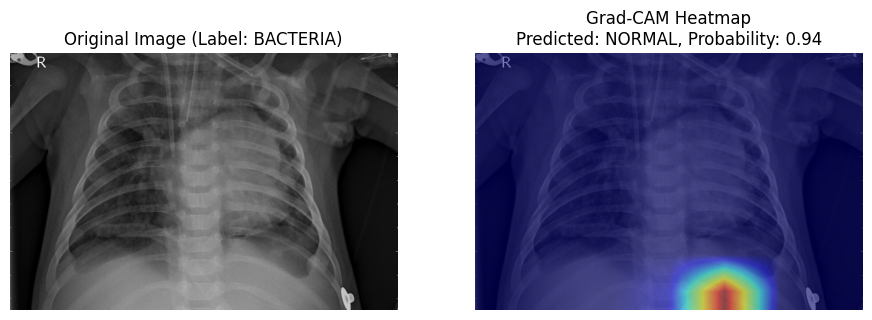

### Examples for class: VIRUS

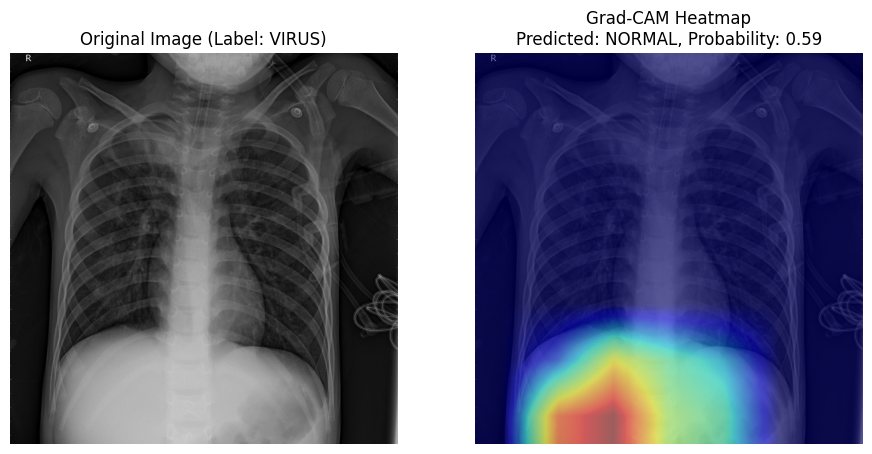

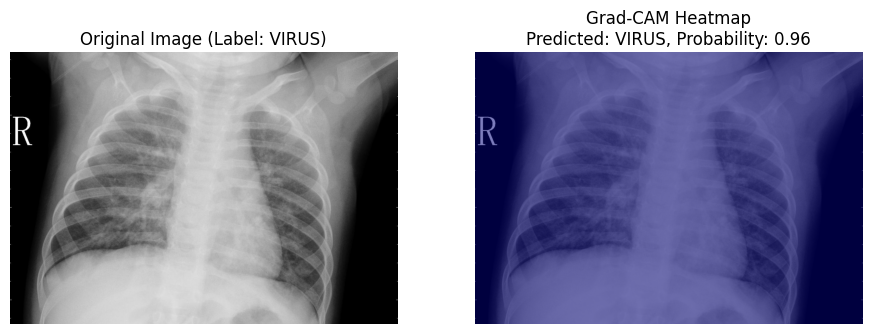

In [8]:
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from torchvision import transforms
from IPython.display import display, Markdown

# Same transforms as used in training
gradcam_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BINARY_LABELS = {0: "NORMAL", 1: "PNEUMONIA"}
MULTI_LABELS = {0: "NORMAL", 1: "BACTERIA", 2: "VIRUS"}

activations = None

def register_hooks(model, model_type='binary'):
    """
    Registers forward and regular backward hooks on the last conv layer.
    Note: regular backward_hook might show a FutureWarning in newer PyTorch versions.
    """
    global activations
    gradients = []
    activations = None

    def forward_hook(module, input, output):
        global activations
        activations = output

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Choose the final conv layer depending on binary or multiclass
    if model_type == 'binary':
        target_layer = model.base_model.layer4[-1].conv2
    else:
        target_layer = model.model.layer4[-1].conv2

    # Clear any existing hooks
    if hasattr(target_layer, '_backward_hooks'):
        target_layer._backward_hooks.clear()
    if hasattr(target_layer, '_forward_hooks'):
        target_layer._forward_hooks.clear()

    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)
    return gradients

def compute_gradcam(image_path, model, transform, model_type='binary'):
    """
    Runs forward + backward pass to create a Grad-CAM heatmap.
    Returns (PIL image, heatmap array, predicted_class, probability, labels).
    """
    global activations
    device = next(model.parameters()).device
    gradients = register_hooks(model, model_type)

    labels = BINARY_LABELS if model_type == 'binary' else MULTI_LABELS

    # 1) Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # 2) Forward pass
    output = model(input_tensor)

    # 3) Determine predicted class and probability
    if model_type == 'binary':
        probability = torch.sigmoid(output).item()
        predicted_class = 1 if probability >= 0.5 else 0
    else:
        probs = torch.softmax(output, dim=1).squeeze()
        predicted_class = probs.argmax().item()
        probability = probs[predicted_class].item()

    # 4) Backward pass on the logit
    model.zero_grad()
    if model_type == 'binary':
        output.backward()
    else:
        output[0, predicted_class].backward()

    # 5) Build Grad-CAM
    grad = gradients[0].cpu().numpy()              # shape [C, H, W]
    act = activations.detach().cpu().numpy()[0]    # shape [C, H, W]

    weights = np.mean(grad, axis=(1, 2))
    gradcam = np.zeros(act.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        gradcam += w * act[i]

    gradcam = np.maximum(gradcam, 0)
    max_val = gradcam.max()
    if max_val > 0:
        gradcam /= max_val
    else:
        gradcam[:] = 0

    gradcam = Image.fromarray(np.uint8(255 * gradcam)).resize(image.size, Image.BILINEAR)
    return image, np.array(gradcam), predicted_class, probability, labels

def visualize_gradcam(image_path, model, transform, true_label, model_type='binary', correct_prediction=None):
    """
    Loads an image -> computes Grad-CAM -> Visualizes in matplotlib.
    """
    image, gradcam, predicted_class, probability, labels = compute_gradcam(
        image_path, model, transform, model_type
    )

    # Create a colored heatmap from the grayscale Grad-CAM
    heatmap_colored = plt.cm.jet(gradcam / 255.0)[:, :, :3]
    heatmap_colored = np.uint8(255 * heatmap_colored)
    overlay = np.uint8(np.array(image) * 0.5 + heatmap_colored * 0.5)

    plt.figure(figsize=(11, 5.5))

    plt.subplot(1, 2, 1)
    plt.title(f"Original Image (Label: {labels[true_label]})")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    title = f"Grad-CAM Heatmap\nPredicted: {labels[predicted_class]}, Probability: {probability:.2f}"
    if correct_prediction is not None and not correct_prediction:
        title += " [WRONG]"
    plt.title(title)
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

def analyze_model(model, transform, model_type='binary', samples_per_class=2):
    """
    Loops through a few examples per class from the test folder and shows Grad-CAM overlays.
    """
    model.eval()
    base_dir = "c:/Dev/PneumoScope/data/test"  # adjust if needed

    if model_type == 'binary':
        class_dirs = {
            0: os.path.join(base_dir, "NORMAL"),
            1: os.path.join(base_dir, "PNEUMONIA")
        }
    else:
        pneumonia_dir = os.path.join(base_dir, "PNEUMONIA")
        class_dirs = {
            0: os.path.join(base_dir, "NORMAL"),
            1: pneumonia_dir,  # Bacteria (filtered by filename)
            2: pneumonia_dir   # Virus (filtered by filename)
        }

    for label, directory in class_dirs.items():
        if not os.path.exists(directory):
            print(f"[WARN] Directory not found: {directory}")
            continue
        
        display(Markdown(f"### Examples for class: "
                         f"{BINARY_LABELS[label] if model_type == 'binary' else MULTI_LABELS[label]}"))

        if model_type == 'binary':
            images = os.listdir(directory)[:samples_per_class]
        else:
            all_images = os.listdir(directory)
            if label == 0:  # NORMAL
                images = all_images[:samples_per_class]
            elif label == 1:  # BACTERIA
                images = [img for img in all_images if 'bacteria' in img.lower()][:samples_per_class]
            else:  # VIRUS
                images = [img for img in all_images if 'virus' in img.lower()][:samples_per_class]

        for img_name in images:
            image_path = os.path.join(directory, img_name)
            visualize_gradcam(image_path, model, transform, label, model_type)

analyze_model(model_bin, gradcam_transform, 'binary')
analyze_model(model_multi, gradcam_transform, 'multi')


## 7. Discussion & Conclusion

### Findings
- **Binary Model**: High AUC (~0.99) indicates that distinguishing Normal vs. Pneumonia is relatively straightforward.  
- **Multiclass Model**: Macro-F1 ~0.71–0.80. The virus class remains trickier due to smaller representation or visual overlap with bacterial pneumonia.  
- **Overfitting**: The binary model can slightly overfit if training metrics far exceed validation; multiclass shows mild overfitting, mitigated by more data/augmentations.  
- **Grad-CAM Observations**: We discovered that many Grad-CAM visualizations show the model focusing on hospital text or corners, which suggests data leakage. Proper **masking or cropping** is recommended so that the model learns from the lungs rather than textual markers.

### Potential Improvements
1. **Hyperparameter Tuning** (learning rate, epochs, batch size) with Optuna.  
2. **Balanced Sampling** for multiclass, especially since virus is underrepresented.  
3. **Enhanced Data Cleaning**: Mask or crop out textual regions to avoid corner-based leakage; unify filenames.  
4. **Architecture Variants**: Try ResNet50, DenseNet, or EfficientNet for possible performance gains.  
5. **Patient-Level Splits**: Ensure images from the same patient do not appear in both train and validation/test sets.

### Ethical & Practical Considerations
Minimizing **false negatives** is crucial in real clinical settings, as missing a pneumonia case can have severe consequences. For safe deployment, extensive validation on diverse data is recommended.

By applying these solutions, we can improve multiclass performance, reduce overfitting, and ensure the model focuses on genuine lung patterns instead of textual cues.

---


# Inference Process

**Run the Flask App:**  
Use the `app.py` script to start the Flask web application for real-time predictions:

```bash
python app.py
```

**Upload and Classify Images:**  
Open your web browser and go to [http://127.0.0.1:5000/](http://127.0.0.1:5000/). Upload a chest X-ray image to classify it as "Normal" or "Pneumonia".

The inference process involves using the trained model to make predictions on new chest X-ray images. Here is a summary of how the inference works:

**Load the Trained Model:**  
The trained model is loaded from a saved checkpoint file. The model's weights are restored to the state they were in after training.

**Preprocess the Input Image:**  
The input image is preprocessed to match the format expected by the model. This includes resizing the image, converting it to a tensor, and normalizing the pixel values.

**Perform Inference:**  
The preprocessed image is passed through the model to obtain the output logits. For binary classification, the logits are converted to probabilities using the sigmoid function. A threshold is applied to determine the final prediction (e.g., 0.5 for binary classification).


## References / Related Work
- Example references to prior pneumonia detection with deep learning.  
- Kaggle dataset: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

---
